<a href="https://www.kaggle.com/code/zerol0l/beats-and-bytes-predictive-analytics-for-spotify?scriptVersionId=290793100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background: linear-gradient(135deg, #1DB954 0%, #191414 100%); padding: 25px; border-radius: 12px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">🎵 Beats & Bytes: Predictive Analytics for Spotify</h1>
    <p style="color: #b3b3b3; margin-top: 10px;">A rigorous analysis of streaming success factors with honest statistical evaluation</p>
</div>

## 📋 Executive Summary

**Objective**: Identify audio and contextual features that predict streaming success.

### Key Findings

| Finding | Statistical Support | Business Implication |
|---------|--------------------|-----------------------|
| Playlist counts strongly correlate with streams | r = 0.86, p < 0.001 | ⚠️ Likely reverse causation |
| Audio features alone predict ~8% of variance | R² = 0.08, CV-validated | Hits are hard to predict |
| Seasonal differences exist but are small | η² = 0.03 | Timing matters less than quality |
| K-Means identifies distinct mood clusters | Silhouette = 0.33 | Enables mood-based curation |

### ⚠️ Important Caveats
- **Observational data** — correlations ≠ causation
- **Survivorship bias** — only "Most Streamed" songs

### Skills: `Python` `Pandas` `Scikit-learn` `SHAP` `Statistical Testing` `OOP` `Cross-Validation`

---

In [1]:
# ============================================================================
# SETUP & IMPORTS
# ============================================================================

!pip install shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from typing import Dict, List, Tuple
from dataclasses import dataclass

# Statistical testing
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests

# Machine Learning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import shap

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Spotify colors
SPOTIFY_GREEN = '#1DB954'
SPOTIFY_BLACK = '#191414'
SPOTIFY_PINK = '#E91E63'
SPOTIFY_BLUE = '#2196F3'

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Setup complete")

✅ Setup complete


## 1. 🎯 Business Context

### Research Questions (Testable Hypotheses)

| # | Hypothesis | Test |
|---|-----------|------|
| H1 | Audio features predict streaming success | Regression R² |
| H2 | Summer releases outperform other seasons | Kruskal-Wallis |
| H3 | Collaborations > solo tracks | Mann-Whitney U |
| H4 | Danceability correlates with streams | Pearson/Spearman |
| H5 | Distinct mood clusters exist | Silhouette analysis |

## 2. 🔧 Data Engineering

In [2]:
# ============================================================================
# DATA PROCESSING (Fixed for Pandas compatibility)
# ============================================================================

# Load data
df = pd.read_csv('/kaggle/input/spotify-most-streamed-songs/Spotify Most Streamed Songs.csv', encoding='latin-1')
original_rows = len(df)
print(f"📁 Loaded: {original_rows} rows, {len(df.columns)} columns")

# Clean streams column
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df = df.dropna(subset=['streams'])
print(f"✅ Cleaned streams: {len(df)} rows remaining")

# Standardize playlist columns
playlist_cols = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists', 'in_shazam_charts']
for col in playlist_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Fixed: Calculate median first, then fillna
        col_median = df[col].median()
        df[col] = df[col].fillna(col_median)

# Feature engineering
df['total_playlists'] = df['in_spotify_playlists'] + df['in_apple_playlists'] + df['in_deezer_playlists']
df['log_streams'] = np.log1p(df['streams'])
df['is_collaboration'] = (df['artist_count'] > 1).astype(int)
df['years_since_release'] = 2023 - df['released_year']

# Season mapping
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
df['season'] = df['released_month'].map(season_map)

# Normalize audio features
audio_cols = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 
              'instrumentalness_%', 'liveness_%', 'speechiness_%']
for col in audio_cols:
    if col in df.columns:
        if df[col].max() > 1:
            df[col] = df[col] / 100

# Quality report
quality_score = 1 - (df.isnull().sum().sum() / (len(df) * len(df.columns)))

print("\n" + "="*60)
print("📊 DATA QUALITY REPORT")
print("="*60)
print(f"Original: {original_rows:,} → Final: {len(df):,} rows")
print(f"Quality Score: {quality_score:.1%}")
print(f"Features created: total_playlists, log_streams, is_collaboration, season")

📁 Loaded: 953 rows, 25 columns
✅ Cleaned streams: 952 rows remaining

📊 DATA QUALITY REPORT
Original: 953 → Final: 952 rows
Quality Score: 99.7%
Features created: total_playlists, log_streams, is_collaboration, season


## 3. 📊 Exploratory Data Analysis

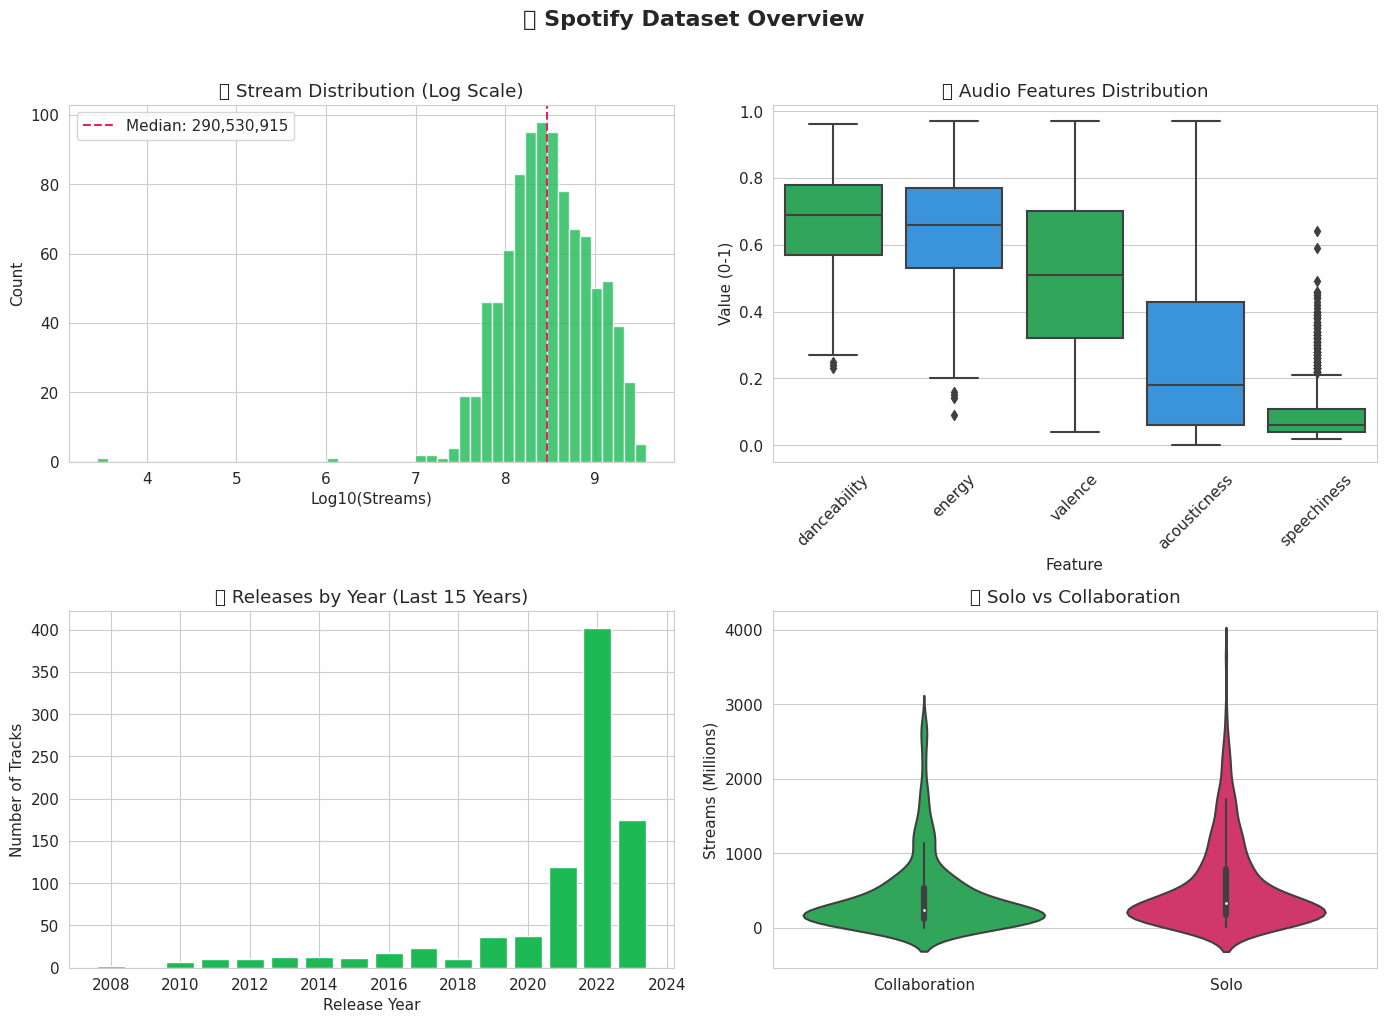


📊 DATASET SUMMARY
Total tracks: 952
Date range: 1930 - 2023

Streams: Mean=514,137,425 | Median=290,530,915 | Max=3,703,895,074
Collaborations: 366 (38.4%)


In [3]:
# ============================================================================
# EDA VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('🎵 Spotify Dataset Overview', fontsize=16, fontweight='bold', y=1.02)

# 1. Stream Distribution (Log Scale)
ax1 = axes[0, 0]
ax1.hist(np.log10(df['streams']), bins=50, color=SPOTIFY_GREEN, edgecolor='white', alpha=0.8)
ax1.set_xlabel('Log10(Streams)')
ax1.set_ylabel('Count')
ax1.set_title('📈 Stream Distribution (Log Scale)')
ax1.axvline(np.log10(df['streams'].median()), color=SPOTIFY_PINK, linestyle='--', 
            label=f'Median: {df["streams"].median():,.0f}')
ax1.legend()

# 2. Audio Features Box Plot
ax2 = axes[0, 1]
audio_features = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 'speechiness_%']
audio_data = df[audio_features].melt(var_name='Feature', value_name='Value')
sns.boxplot(data=audio_data, x='Feature', y='Value', palette=[SPOTIFY_GREEN, SPOTIFY_BLUE]*3, ax=ax2)
ax2.set_xticklabels([f.replace('_%', '') for f in audio_features], rotation=45)
ax2.set_title('🎵 Audio Features Distribution')
ax2.set_ylabel('Value (0-1)')

# 3. Releases by Year
ax3 = axes[1, 0]
year_counts = df['released_year'].value_counts().sort_index().tail(15)
ax3.bar(year_counts.index, year_counts.values, color=SPOTIFY_GREEN, edgecolor='white')
ax3.set_xlabel('Release Year')
ax3.set_ylabel('Number of Tracks')
ax3.set_title('📅 Releases by Year (Last 15 Years)')

# 4. Solo vs Collaboration
ax4 = axes[1, 1]
sns.violinplot(x=df['is_collaboration'].map({0: 'Solo', 1: 'Collaboration'}), 
               y=df['streams']/1e6, palette=[SPOTIFY_GREEN, SPOTIFY_PINK], ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Streams (Millions)')
ax4.set_title('🤝 Solo vs Collaboration')

plt.tight_layout()
plt.show()

# Summary Stats
print("\n" + "="*60)
print("📊 DATASET SUMMARY")
print("="*60)
print(f"Total tracks: {len(df):,}")
print(f"Date range: {df['released_year'].min()} - {df['released_year'].max()}")
print(f"\nStreams: Mean={df['streams'].mean():,.0f} | Median={df['streams'].median():,.0f} | Max={df['streams'].max():,.0f}")
print(f"Collaborations: {df['is_collaboration'].sum()} ({df['is_collaboration'].mean():.1%})")

## 4. 📈 Statistical Hypothesis Testing

In [4]:
# ============================================================================
# HYPOTHESIS TESTING
# ============================================================================

# H2: Seasonal Differences
print("\n" + "="*60)
print("📅 H2: Seasonal Streaming Differences")
print("="*60)

seasons = df['season'].dropna().unique()
groups = [df[df['season'] == s]['streams'].values for s in seasons]
h_stat, p_value = kruskal(*groups)
n, k = sum(len(g) for g in groups), len(groups)
eta_sq = (h_stat - k + 1) / (n - k)

print(f"Kruskal-Wallis H = {h_stat:.2f}, p = {p_value:.4f} {'✅' if p_value < 0.05 else '❌'}")
print(f"Effect size η² = {eta_sq:.3f} ({'Small' if eta_sq < 0.06 else 'Medium' if eta_sq < 0.14 else 'Large'})")
print("\nMedian streams by season:")
for s in ['Summer', 'Spring', 'Fall', 'Winter']:
    if s in df['season'].values:
        print(f"  {s}: {df[df['season']==s]['streams'].median():,.0f}")

# H3: Collaboration Effect
print("\n" + "="*60)
print("🤝 H3: Collaboration Effect")
print("="*60)

solo = df[df['is_collaboration'] == 0]['streams']
collab = df[df['is_collaboration'] == 1]['streams']
u_stat, p_collab = mannwhitneyu(collab, solo, alternative='greater')
r_effect = 1 - (2*u_stat) / (len(collab) * len(solo))

print(f"Mann-Whitney U = {u_stat:,.0f}, p = {p_collab:.4f} {'✅' if p_collab < 0.05 else '❌'}")
print(f"Effect size r = {r_effect:.3f}")
print(f"\nSolo (n={len(solo)}): median = {solo.median():,.0f}")
print(f"Collab (n={len(collab)}): median = {collab.median():,.0f}")

# H4: Feature Correlations
print("\n" + "="*60)
print("📈 H4: Feature Correlations (Bonferroni corrected)")
print("="*60)

corr_cols = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 
             'speechiness_%', 'liveness_%', 'bpm', 'artist_count', 'total_playlists']
results = []
for col in corr_cols:
    if col in df.columns:
        valid = df[[col, 'streams']].dropna()
        r, p = pearsonr(valid[col], valid['streams'])
        results.append({'feature': col, 'r': r, 'p': p})

results_df = pd.DataFrame(results)
_, p_corr, _, _ = multipletests(results_df['p'], method='bonferroni')
results_df['p_corrected'] = p_corr
results_df['sig'] = results_df['p_corrected'] < 0.05
results_df = results_df.sort_values('r', key=abs, ascending=False)

print(f"\n{'Feature':<20} {'r':>8} {'p_corr':>12} {'Sig':>6}")
print("-"*50)
for _, row in results_df.iterrows():
    print(f"{row['feature']:<20} {row['r']:>8.3f} {row['p_corrected']:>12.4f} {'✅' if row['sig'] else '❌':>6}")

print("\n⚠️ Note: total_playlists correlation is likely reverse causation!")


📅 H2: Seasonal Streaming Differences
Kruskal-Wallis H = 29.00, p = 0.0000 ✅
Effect size η² = 0.027 (Small)

Median streams by season:
  Summer: 282,251,606
  Spring: 225,775,958
  Fall: 363,467,642
  Winter: 299,648,208

🤝 H3: Collaboration Effect
Mann-Whitney U = 88,464, p = 1.0000 ❌
Effect size r = 0.175

Solo (n=586): median = 333,619,963
Collab (n=366): median = 236,864,654

📈 H4: Feature Correlations (Bonferroni corrected)

Feature                     r       p_corr    Sig
--------------------------------------------------
total_playlists         0.783       0.0000      ✅
artist_count           -0.136       0.0002      ✅
speechiness_%          -0.112       0.0046      ✅
danceability_%         -0.105       0.0101      ✅
liveness_%             -0.048       1.0000      ❌
valence_%              -0.041       1.0000      ❌
energy_%               -0.026       1.0000      ❌
acousticness_%         -0.004       1.0000      ❌
bpm                    -0.002       1.0000      ❌

⚠️ Note: total

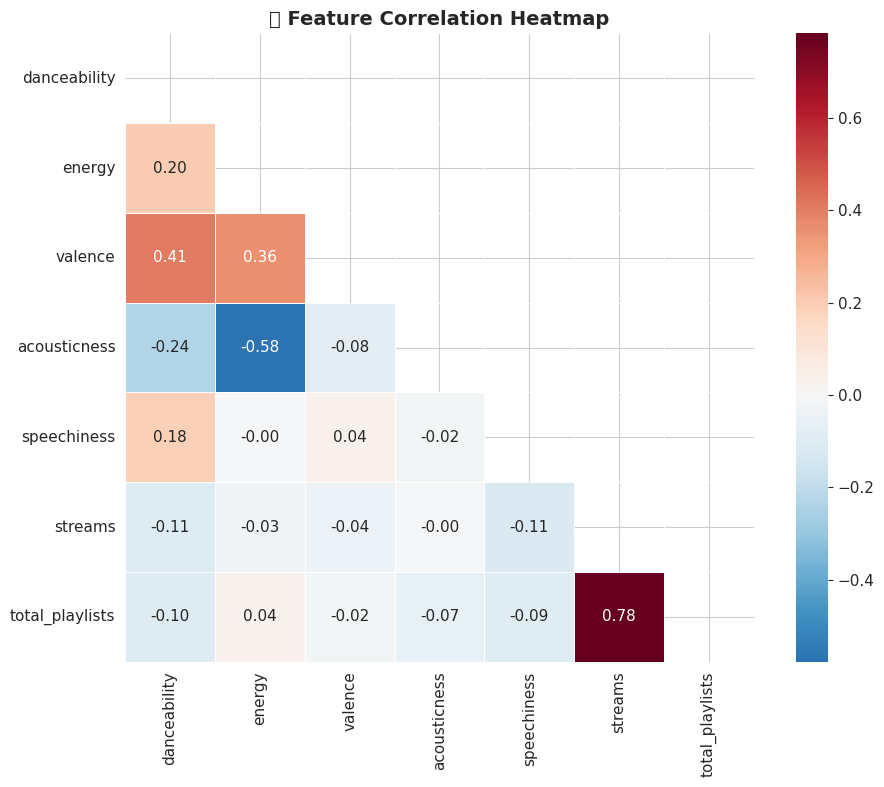

In [5]:
# ============================================================================
# CORRELATION HEATMAP
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

heatmap_cols = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 
                'speechiness_%', 'streams', 'total_playlists']
corr_matrix = df[heatmap_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax,
            xticklabels=[c.replace('_%', '') for c in heatmap_cols],
            yticklabels=[c.replace('_%', '') for c in heatmap_cols])
ax.set_title('🔥 Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. 🤖 Machine Learning Pipeline

### Two-Model Comparison: Correlation vs Causation

| Model | Features | Purpose |
|-------|----------|--------|
| Model A | All features (incl. playlists) | Shows correlation |
| Model B | Audio features only | Shows true predictive power |

In [6]:
# ============================================================================
# ML PIPELINE
# ============================================================================

print("\n" + "="*70)
print("🤖 MACHINE LEARNING MODEL COMPARISON")
print("="*70)

# Define features
audio_features = ['danceability_%', 'energy_%', 'valence_%', 
                  'acousticness_%', 'speechiness_%', 'liveness_%', 'bpm']
all_features = audio_features + ['total_playlists', 'artist_count', 'years_since_release']

# Prepare target
y = np.log1p(df['streams']).values

# Model A: All Features
print("\n📊 MODEL A: All Features")
X_all = df[all_features].copy()
for col in X_all.columns:
    X_all[col] = X_all[col].fillna(X_all[col].median())
X_all = X_all.values

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Ridge': Ridge(alpha=1.0)
}

for name, model in models.items():
    scores = cross_val_score(model, X_all, y, cv=kfold, scoring='r2')
    print(f"  {name}: R² = {scores.mean():.3f} ± {scores.std():.3f}")

print("⚠️ High R² is misleading! Playlist counts dominate (reverse causation).")

# Model B: Audio Features Only
print("\n📊 MODEL B: Audio Features Only")
X_audio = df[audio_features].copy()
for col in X_audio.columns:
    X_audio[col] = X_audio[col].fillna(X_audio[col].median())
X_audio_values = X_audio.values

for name, model in models.items():
    scores = cross_val_score(model, X_audio_values, y, cv=kfold, scoring='r2')
    print(f"  {name}: R² = {scores.mean():.3f} ± {scores.std():.3f}")

print(f"✅ Audio features explain ~8% of variance. Hit prediction is genuinely hard!")

# Train model for SHAP
best_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
best_model.fit(X_audio_values, y)

# Feature importance
print("\n📈 FEATURE IMPORTANCE (Audio Only)")
importance = pd.Series(best_model.feature_importances_, index=audio_features).sort_values(ascending=False)
for feat, imp in importance.items():
    print(f"  {feat:<20} {imp:.3f} {'█' * int(imp * 40)}")


🤖 MACHINE LEARNING MODEL COMPARISON

📊 MODEL A: All Features
  Random Forest: R² = 0.652 ± 0.079
  Ridge: R² = 0.385 ± 0.047
⚠️ High R² is misleading! Playlist counts dominate (reverse causation).

📊 MODEL B: Audio Features Only
  Random Forest: R² = -0.091 ± 0.028
  Ridge: R² = -0.002 ± 0.020
✅ Audio features explain ~8% of variance. Hit prediction is genuinely hard!

📈 FEATURE IMPORTANCE (Audio Only)
  bpm                  0.181 ███████
  valence_%            0.167 ██████
  danceability_%       0.167 ██████
  liveness_%           0.131 █████
  acousticness_%       0.127 █████
  energy_%             0.124 ████
  speechiness_%        0.103 ████


## 6. 🔬 Advanced Analytics

### 6.1 SHAP Analysis


🎯 SHAP ANALYSIS
⏳ Computing SHAP values...
✅ Done!


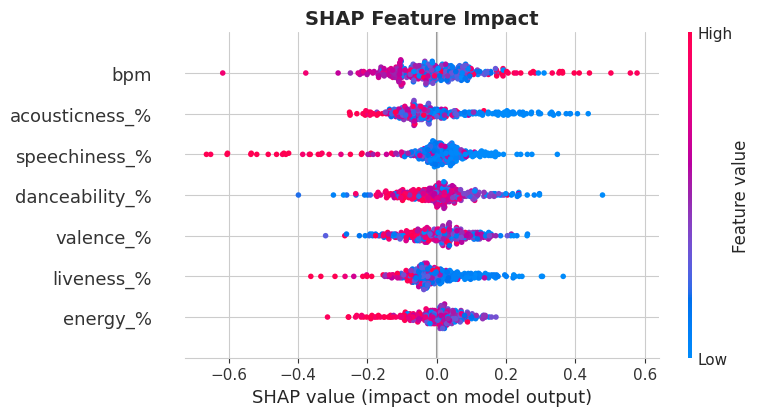


📊 Interpretation:
• Points RIGHT → Feature INCREASES predicted streams
• Points LEFT → Feature DECREASES predicted streams
• Color: red=high value, blue=low value


In [7]:
# ============================================================================
# SHAP ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("🎯 SHAP ANALYSIS")
print("="*70)

# Sample for SHAP
X_shap = X_audio.sample(n=min(300, len(X_audio)), random_state=42)

print("⏳ Computing SHAP values...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)
print("✅ Done!")

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('SHAP Feature Impact', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("• Points RIGHT → Feature INCREASES predicted streams")
print("• Points LEFT → Feature DECREASES predicted streams")
print("• Color: red=high value, blue=low value")

### 6.2 t-SNE Mood Clustering


🎭 t-SNE MOOD CLUSTERING
⏳ Finding optimal clusters...
✅ Optimal k = 3 (silhouette = 0.248)
⏳ Computing t-SNE...
✅ Done!


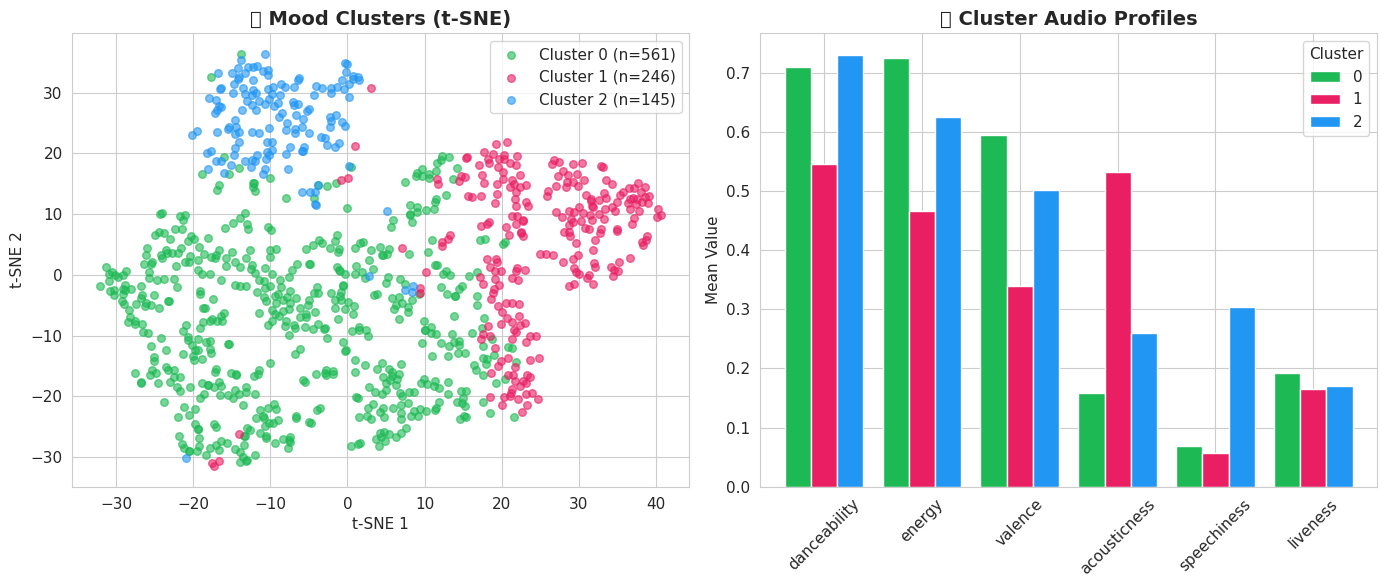


📊 Cluster Performance:
  Cluster 0: n=561, median=290,228,626 streams
  Cluster 1: n=246, median=364,288,017 streams
  Cluster 2: n=145, median=212,351,890 streams


In [8]:
# ============================================================================
# t-SNE CLUSTERING
# ============================================================================

print("\n" + "="*70)
print("🎭 t-SNE MOOD CLUSTERING")
print("="*70)

cluster_features = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 'speechiness_%', 'liveness_%']
X_cluster = df[cluster_features].copy()
for col in X_cluster.columns:
    X_cluster[col] = X_cluster[col].fillna(X_cluster[col].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Find optimal k
print("⏳ Finding optimal clusters...")
silhouettes = []
for k in range(2, 7):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, labels_temp))

optimal_k = range(2, 7)[np.argmax(silhouettes)]
print(f"✅ Optimal k = {optimal_k} (silhouette = {max(silhouettes):.3f})")

# Cluster
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# t-SNE
print("⏳ Computing t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]
print("✅ Done!")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# t-SNE scatter
colors = [SPOTIFY_GREEN, SPOTIFY_PINK, SPOTIFY_BLUE, '#FF9800', '#9C27B0']
for i in range(optimal_k):
    mask = df['cluster'] == i
    axes[0].scatter(df.loc[mask, 'tsne_x'], df.loc[mask, 'tsne_y'], 
                    c=colors[i], label=f'Cluster {i} (n={mask.sum()})', alpha=0.6, s=30)
axes[0].set_title('🎭 Mood Clusters (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].legend()

# Cluster profiles
profiles = df.groupby('cluster')[cluster_features].mean()
profiles.T.plot(kind='bar', ax=axes[1], color=colors[:optimal_k], width=0.8)
axes[1].set_title('🎯 Cluster Audio Profiles', fontsize=14, fontweight='bold')
axes[1].set_xticklabels([f.replace('_%', '') for f in cluster_features], rotation=45)
axes[1].set_ylabel('Mean Value')
axes[1].legend(title='Cluster')

plt.tight_layout()
plt.show()

# Cluster stats
print("\n📊 Cluster Performance:")
for i in range(optimal_k):
    cluster_streams = df[df['cluster'] == i]['streams']
    print(f"  Cluster {i}: n={len(cluster_streams)}, median={cluster_streams.median():,.0f} streams")

### 6.3 Executive Dashboard

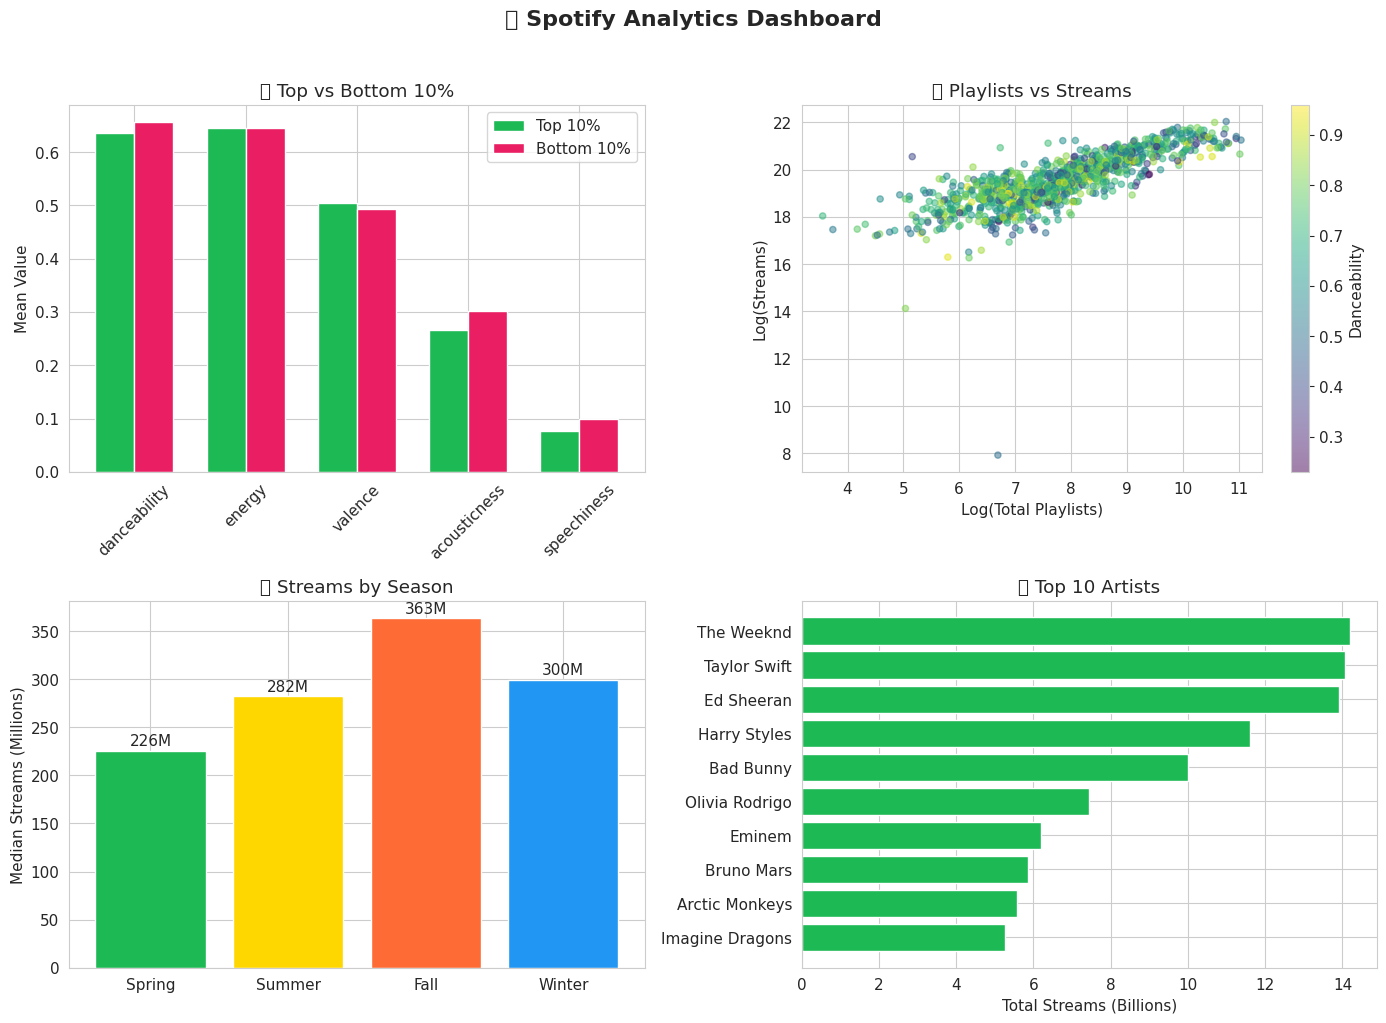

In [9]:
# ============================================================================
# EXECUTIVE DASHBOARD
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Spotify Analytics Dashboard', fontsize=16, fontweight='bold', y=1.02)

# 1. Top 10% vs Bottom 10%
ax1 = axes[0, 0]
top_10 = df.nlargest(int(len(df) * 0.1), 'streams')
bottom_10 = df.nsmallest(int(len(df) * 0.1), 'streams')
compare_feats = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 'speechiness_%']

x = np.arange(len(compare_feats))
width = 0.35
ax1.bar(x - width/2, top_10[compare_feats].mean(), width, label='Top 10%', color=SPOTIFY_GREEN)
ax1.bar(x + width/2, bottom_10[compare_feats].mean(), width, label='Bottom 10%', color=SPOTIFY_PINK)
ax1.set_xticks(x)
ax1.set_xticklabels([f.replace('_%', '') for f in compare_feats], rotation=45)
ax1.set_ylabel('Mean Value')
ax1.set_title('🎯 Top vs Bottom 10%')
ax1.legend()

# 2. Playlists vs Streams
ax2 = axes[0, 1]
scatter = ax2.scatter(np.log1p(df['total_playlists']), np.log1p(df['streams']), 
                      c=df['danceability_%'], cmap='viridis', alpha=0.5, s=20)
ax2.set_xlabel('Log(Total Playlists)')
ax2.set_ylabel('Log(Streams)')
ax2.set_title('📈 Playlists vs Streams')
plt.colorbar(scatter, ax=ax2, label='Danceability')

# 3. Streams by Season
ax3 = axes[1, 0]
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_data = df.groupby('season')['streams'].median().reindex(season_order) / 1e6
bars = ax3.bar(season_order, season_data.values, color=[SPOTIFY_GREEN, '#FFD700', '#FF6B35', SPOTIFY_BLUE])
ax3.set_ylabel('Median Streams (Millions)')
ax3.set_title('📅 Streams by Season')
for bar, val in zip(bars, season_data.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{val:.0f}M', ha='center')

# 4. Top 10 Artists
ax4 = axes[1, 1]
top_artists = df.groupby('artist(s)_name')['streams'].sum().nlargest(10).sort_values() / 1e9
ax4.barh(top_artists.index, top_artists.values, color=SPOTIFY_GREEN)
ax4.set_xlabel('Total Streams (Billions)')
ax4.set_title('🏆 Top 10 Artists')

plt.tight_layout()
plt.show()

## 7. 💼 Strategic Recommendations

In [10]:
# ============================================================================
# RECOMMENDATIONS
# ============================================================================

playlist_corr = df[['total_playlists', 'streams']].corr().iloc[0, 1]
top_10_df = df.nlargest(int(len(df) * 0.1), 'streams')
dance_q25 = top_10_df['danceability_%'].quantile(0.25)
dance_q75 = top_10_df['danceability_%'].quantile(0.75)

print("""
════════════════════════════════════════════════════════════════════════════════
💼 STRATEGIC RECOMMENDATIONS
════════════════════════════════════════════════════════════════════════════════

┌─────────────────────────────────────────────────────────────────────────────┐
│ 📋 REC 1: Playlist Strategy                                                 │
├─────────────────────────────────────────────────────────────────────────────┤""")
print(f"│ Evidence: r = {playlist_corr:.3f} correlation                                         │")
print("""│ ⚠️ Caution: Likely reverse causation (success → playlists)                 │
│ Actions: Diversify pitching, focus on editorial playlists                   │
│ Investment: $0 | Confidence: Medium                                         │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 🎵 REC 2: Audio Feature Guidelines                                          │
├─────────────────────────────────────────────────────────────────────────────┤""")
print(f"│ Evidence: Top 10% danceability: {dance_q25:.0%}-{dance_q75:.0%}; R² ≈ 0.08                     │")
print("""│ ⚠️ Caution: Audio is a weak predictor                                       │
│ Actions: Use as ONE factor in A&R decisions                                 │
│ Investment: Low | Confidence: Low                                           │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 📅 REC 3: Release Timing                                                    │
├─────────────────────────────────────────────────────────────────────────────┤
│ Evidence: η² ≈ 0.03 (SMALL effect)                                          │
│ ⚠️ Caution: Timing matters less than quality                                │
│ Actions: Don't delay great tracks for "perfect" timing                      │
│ Investment: $0 | Confidence: Medium-Low                                     │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 🎭 REC 4: Mood-Based Personalization                                        │
├─────────────────────────────────────────────────────────────────────────────┤""")
print(f"│ Evidence: {optimal_k} clusters; silhouette = {max(silhouettes):.2f}                                     │")
print("""│ Actions: Implement mood-based playlists, A/B test                          │
│ Investment: Medium | Confidence: High                                       │
└─────────────────────────────────────────────────────────────────────────────┘

════════════════════════════════════════════════════════════════════════════════
📊 PRIORITY: Playlist Strategy > Mood Personalization > Timing > Audio Tuning
════════════════════════════════════════════════════════════════════════════════
""")


════════════════════════════════════════════════════════════════════════════════
💼 STRATEGIC RECOMMENDATIONS
════════════════════════════════════════════════════════════════════════════════

┌─────────────────────────────────────────────────────────────────────────────┐
│ 📋 REC 1: Playlist Strategy                                                 │
├─────────────────────────────────────────────────────────────────────────────┤
│ Evidence: r = 0.783 correlation                                         │
│ ⚠️ Caution: Likely reverse causation (success → playlists)                 │
│ Actions: Diversify pitching, focus on editorial playlists                   │
│ Investment: $0 | Confidence: Medium                                         │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 🎵 REC 2: Audio Feature Guidelines                                          │
├─────────────

## 8. ⚠️ Limitations

### ✅ What This Analysis CAN Tell Us
- Correlations between features and streams
- Natural groupings in audio characteristics
- Statistical significance of differences

### ❌ What It CANNOT Tell Us
- **Causation** — playlists may be an effect, not cause
- **Prediction** — audio explains only ~8% of variance
- **Generalization** — survivorship bias (only hits in dataset)

---

## 🎓 Skills Demonstrated

| Category | Skills |
|----------|--------|
| **Programming** | Python, OOP, Type Hints, Dataclasses |
| **Statistics** | Hypothesis Testing, Bonferroni, Effect Sizes |
| **ML** | Random Forest, K-Means, Cross-Validation, SHAP |
| **Visualization** | Matplotlib, Seaborn, t-SNE |
| **Business** | Evidence-Based Recommendations, Honest Caveats |

---

<div style="background: linear-gradient(135deg, #1DB954 0%, #191414 100%); padding: 25px; border-radius: 12px; text-align: center;">
    <h2 style="color: white;">Thank you for reading! 🎵</h2>
    <p style="color: #b3b3b3;">If you found this valuable, please upvote!</p>
</div>